In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
import time
import pickle

from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFpr, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.impute import  SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm import tqdm,trange
from collections import defaultdict,Counter
from text_to_num import text2num,alpha2digit

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
def model_evaluation(model, title, raw_data, include_seconds = False, test_data = pd.DataFrame()):
    data = raw_data.loc[np.isnan(raw_data['seconds']) == False,:] if include_seconds else raw_data
    x = data.drop('duration_label',axis=1)
    y = data['duration_label']
    xtrain, xtest, ytrain, ytest = train_test_split(x,y)
    types = ['Label 1', 'Label 2', 'Label 3']#str(y.unique())

    start = time.time()
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    print(f'Model {title:s} has accuracy of: {100*accuracy_score(ypred, ytest):.2f}%, runtime {time.time()-start:3.2f} seconds')
    print(classification_report(ytest, ypred,target_names=types))
    sns.heatmap(pd.DataFrame(confusion_matrix(ytest, ypred), index=types, columns=types), annot=True, fmt='d')
    plt.title("Confusion Matrix of Model "+title)
    plt.xlabel("Predicted")
    plt.ylabel("Truth Label")
    plt.yticks(rotation=0)
    plt.show()

    if not test_data.empty:
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp.fit(x)

        xtestdata = imp.transform(test_data)
        model.fit(x,y)
        ytestdata = model.predict(xtestdata)
        out = pd.DataFrame({'duration_label':ytestdata})
        out.index += 1
        out.to_csv('output/out_'+title+'.csv',index_label = 'id')

In [77]:
train_data = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_train.csv').drop(['name','steps','ingredients'], axis=1)
train_data_seconds = pd.read_csv('COMP30027_2021_Project2_datasets\\input\\train_seconds.csv').drop(['name','steps','ingredients'], axis=1)
train_step_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\train_steps_doc2vec100.csv',header=None, names = ['step'+str(i) for i in range(100)])
train_ingr_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\train_ingr_doc2vec100.csv',header=None, names = ['ing'+str(i) for i in range(100)])
train_name_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\train_name_doc2vec100.csv',header=None, names = ['name'+str(i) for i in range(100)])
train_step_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\train_steps_doc2vec50.csv',header=None, names = ['step'+str(i) for i in range(50)])
train_ingr_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\train_ingr_doc2vec50.csv',header=None, names = ['ing'+str(i) for i in range(50)])
train_name_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\train_name_doc2vec50.csv',header=None, names = ['name'+str(i) for i in range(50)])

test_data = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_test.csv').drop(['name','steps','ingredients'], axis=1)
test_data_seconds = pd.read_csv('COMP30027_2021_Project2_datasets\\input\\test_seconds.csv').drop(['name','steps','ingredients'], axis=1)
test_step_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\test_steps_doc2vec100.csv',header=None, names = ['step'+str(i) for i in range(100)])
test_ingr_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\test_ingr_doc2vec100.csv',header=None, names = ['ing'+str(i) for i in range(100)])
test_name_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\test_name_doc2vec100.csv',header=None, names = ['name'+str(i) for i in range(100)])
test_step_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\test_steps_doc2vec50.csv',header=None, names = ['step'+str(i) for i in range(50)])
test_ingr_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\test_ingr_doc2vec50.csv',header=None, names = ['ing'+str(i) for i in range(50)])
test_name_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\test_name_doc2vec50.csv',header=None, names = ['name'+str(i) for i in range(50)])

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
Mean for duration  1 :  6878.063459138413
Mean for duration  2 :  6076.938981150072
Mean for duration  3 :  9009.899835040269


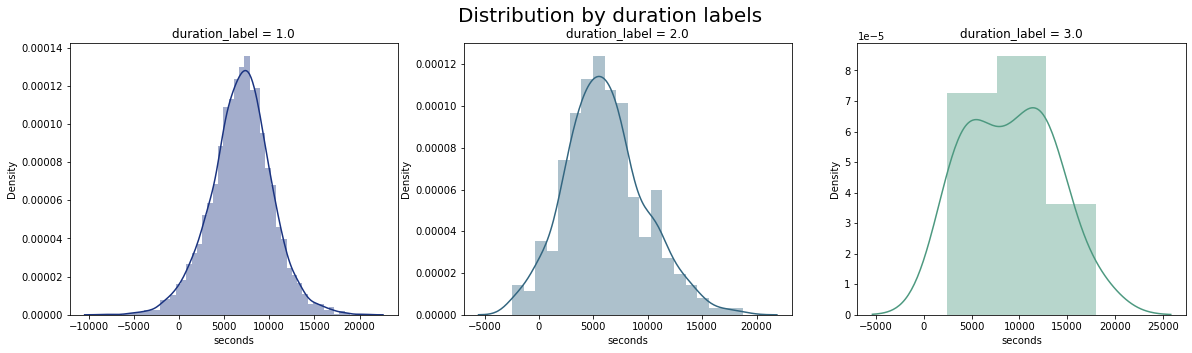

In [42]:
data = pd.concat([train_data_seconds,train_step_50,train_ingr_50,train_ingr_50],axis=1)
sec_train = data.loc[np.isnan(data['seconds']) == False,:]
sec_test = data.loc[np.isnan(data['seconds']),:]

x_train = sec_train.drop(['seconds','duration_label','n_steps','n_ingredients'], axis = 1)
y_train = sec_train['seconds']
x_test = sec_test.drop(['seconds','duration_label','n_steps','n_ingredients'], axis = 1)

lir = LinearRegression()
lir.fit(x_train, y_train)
y_pred = lir.predict(x_test)
sec_test.loc[:,'seconds'] = y_pred

[print('Mean for duration ',i+1,': ',sec_test.loc[sec_test.duration_label == i+1,'seconds'].mean()) for i in range(3)]
warnings.simplefilter("ignore", category=FutureWarning)
fig,ax = plt.subplots(1,3, figsize=(20,5))
fig.suptitle('Distribution by duration labels',size=20)
for i, data_small in sec_test.groupby('duration_label'):
    #data_small['seconds'].hist(density=True, alpha=0.7, ax=ax[int(i-1)], label=i)
    sns.distplot(data_small['seconds'],kde=True, hist=True, ax=ax[int(i-1)], label=i, color=(0.1*i,0.2*i,0.5))
    #ax[int(i-1)].set_xlim([0,35000*i])
    ax[int(i-1)].set_title("duration_label = "+str(i))
    ax[int(i-1)].set_xlabel('seconds')

Model Stacking with second guess has accuracy of: 76.36%, runtime 51.09 seconds
              precision    recall  f1-score   support

     Label 1       0.76      0.74      0.75      4375
     Label 2       0.77      0.80      0.79      5099
     Label 3       0.69      0.63      0.66       526

    accuracy                           0.76     10000
   macro avg       0.74      0.72      0.73     10000
weighted avg       0.76      0.76      0.76     10000



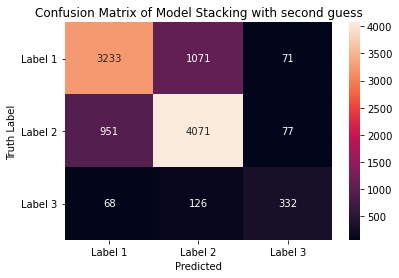

In [41]:
data = pd.concat([sec_train,sec_test],axis=0)
c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = GaussianNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'Stacking with second guess', data, include_seconds=True)

Model Decision Tree has accuracy of: 67.96%, runtime 6.19 seconds
              precision    recall  f1-score   support

     Label 1       0.62      0.62      0.62      3304
     Label 2       0.73      0.74      0.74      4933
     Label 3       0.56      0.51      0.53       522

    accuracy                           0.68      8759
   macro avg       0.64      0.62      0.63      8759
weighted avg       0.68      0.68      0.68      8759



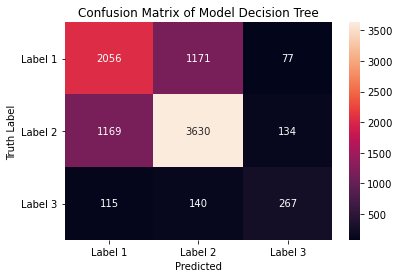

In [5]:
data = pd.concat([train_data_seconds,train_step_100],axis=1)
model_evaluation(DecisionTreeClassifier(), 'Decision Tree', data, include_seconds=True)

Model KNN_Seconds_vec100steps has accuracy of: 77.03%, runtime 3.17 seconds
              precision    recall  f1-score   support

     Label 1       0.70      0.77      0.73      3215
     Label 2       0.84      0.78      0.81      5023
     Label 3       0.65      0.67      0.66       521

    accuracy                           0.77      8759
   macro avg       0.73      0.74      0.73      8759
weighted avg       0.78      0.77      0.77      8759



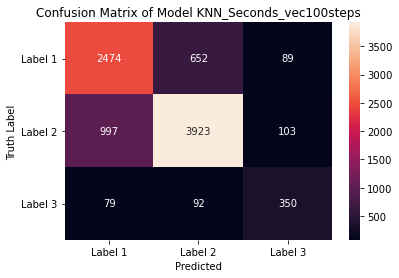

In [18]:
data = pd.concat([train_data_seconds,train_step_100],axis=1)
test = pd.concat([test_data_seconds,test_step_100],axis=1)
model_evaluation(KNeighborsClassifier(n_neighbors=38), 'KNN_Seconds_vec100steps', data, include_seconds=True, test_data=test)

Model Decision Tree has accuracy of: 56.16%, runtime 18.28 seconds
              precision    recall  f1-score   support

     Label 1       0.57      0.56      0.57      4448
     Label 2       0.61      0.61      0.61      5055
     Label 3       0.08      0.09      0.09       497

    accuracy                           0.56     10000
   macro avg       0.42      0.42      0.42     10000
weighted avg       0.56      0.56      0.56     10000



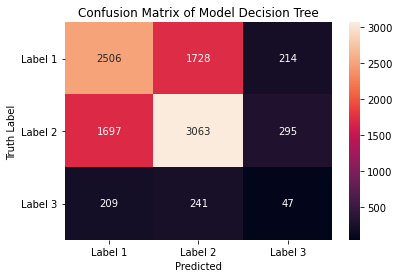

In [8]:
data = pd.concat([train_data,train_step_100,train_ingr_100,train_name_100],axis=1)
model_evaluation(DecisionTreeClassifier(), 'Decision Tree', data)

Model StackingVec50steps has accuracy of: 70.99%, runtime 25.03 seconds
              precision    recall  f1-score   support

     Label 1       0.71      0.71      0.71      4415
     Label 2       0.71      0.76      0.74      5058
     Label 3       0.62      0.23      0.33       527

    accuracy                           0.71     10000
   macro avg       0.68      0.57      0.59     10000
weighted avg       0.71      0.71      0.70     10000



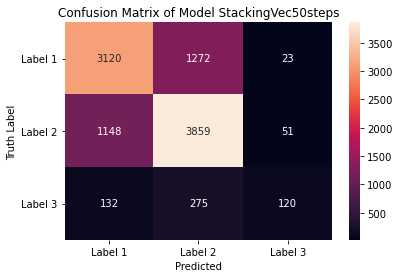

In [25]:
c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = GaussianNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

data = pd.concat([train_data,train_step_50],axis=1)
#test = pd.concat([test_data_seconds,test_step_50],axis=1)
model_evaluation(sclf, 'StackingVec50steps', data, include_seconds=False)

Model StackingSecondsVec100steps has accuracy of: 76.74%, runtime 50.12 seconds
              precision    recall  f1-score   support

     Label 1       0.74      0.69      0.72      3326
     Label 2       0.79      0.83      0.81      4922
     Label 3       0.64      0.69      0.66       517

    accuracy                           0.77      8765
   macro avg       0.73      0.73      0.73      8765
weighted avg       0.77      0.77      0.77      8765



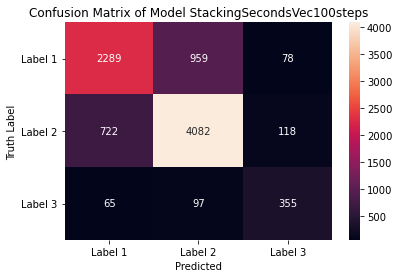

In [67]:
c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = GaussianNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

data = pd.concat([train_data_seconds,train_step_100],axis=1)
test = pd.concat([test_data_seconds,test_step_100],axis=1)
model_evaluation(sclf, 'StackingSecondsVec100steps', data, include_seconds=True, test_data=test)

Model StackingSecondsVec50steps has accuracy of: 77.28%, runtime 38.86 seconds
              precision    recall  f1-score   support

     Label 1       0.74      0.71      0.72      3299
     Label 2       0.80      0.83      0.82      4973
     Label 3       0.67      0.63      0.65       493

    accuracy                           0.77      8765
   macro avg       0.74      0.72      0.73      8765
weighted avg       0.77      0.77      0.77      8765



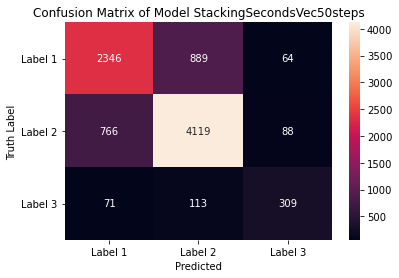

In [69]:
c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = GaussianNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

data = pd.concat([train_data_seconds,train_step_50],axis=1)
test = pd.concat([test_data_seconds,test_step_50],axis=1)
model_evaluation(sclf, 'StackingSecondsVec50steps', data, include_seconds=True, test_data=test)

Model StackingSecondsVec50steps has accuracy of: 77.57%, runtime 22.52 seconds
              precision    recall  f1-score   support

     Label 1       0.78      0.75      0.76      4447
     Label 2       0.78      0.82      0.80      5025
     Label 3       0.68      0.60      0.64       509

    accuracy                           0.78      9981
   macro avg       0.75      0.72      0.73      9981
weighted avg       0.78      0.78      0.77      9981



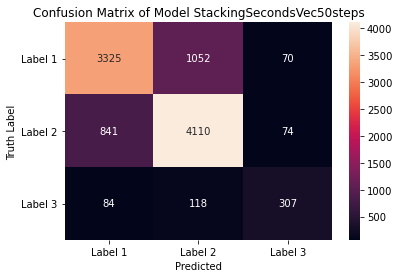

In [78]:
c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = GaussianNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

data = pd.concat([train_data_seconds,train_step_50],axis=1)
test = pd.concat([test_data_seconds,test_step_50],axis=1)
model_evaluation(sclf, 'StackingSecondsVec50steps', data, include_seconds=True, test_data=test)

In [40]:
data = pd.concat([train_data_seconds,train_step_50],axis=1)
data = data.loc[np.isnan(data['seconds']) == False,:]
x = data.drop('duration_label',axis=1)
y = data['duration_label']
xtrain, xtest, ytrain, ytest = train_test_split(x,y)

features = xtrain.columns
k_best = SelectPercentile(mutual_info_classif, percentile=50).fit(xtrain, ytrain)
topfeatures = [features[i] for i in k_best.get_support(indices=True)]

Model StackingSecondsVec50steps, top 10% has accuracy of: 76.84%, runtime 8.30 seconds
              precision    recall  f1-score   support

     Label 1       0.73      0.71      0.72      3348
     Label 2       0.80      0.82      0.81      4914
     Label 3       0.70      0.62      0.66       497

    accuracy                           0.77      8759
   macro avg       0.74      0.72      0.73      8759
weighted avg       0.77      0.77      0.77      8759



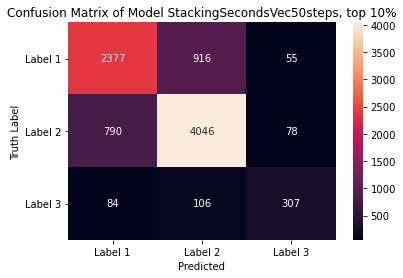

Model StackingSecondsVec50steps, top 20% has accuracy of: 77.36%, runtime 7.25 seconds
              precision    recall  f1-score   support

     Label 1       0.75      0.71      0.73      3385
     Label 2       0.80      0.83      0.81      4847
     Label 3       0.67      0.69      0.68       527

    accuracy                           0.77      8759
   macro avg       0.74      0.74      0.74      8759
weighted avg       0.77      0.77      0.77      8759



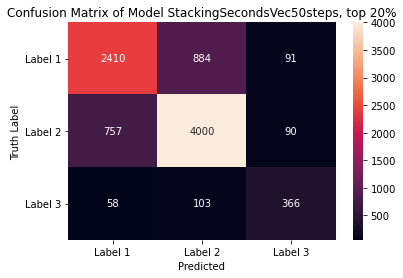

Model StackingSecondsVec50steps, top 30% has accuracy of: 77.21%, runtime 9.26 seconds
              precision    recall  f1-score   support

     Label 1       0.73      0.71      0.72      3299
     Label 2       0.81      0.83      0.82      4965
     Label 3       0.67      0.66      0.67       495

    accuracy                           0.77      8759
   macro avg       0.74      0.73      0.73      8759
weighted avg       0.77      0.77      0.77      8759



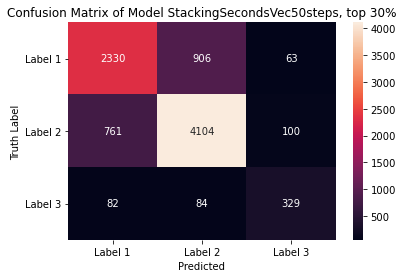

Model StackingSecondsVec50steps, top 40% has accuracy of: 77.45%, runtime 13.27 seconds
              precision    recall  f1-score   support

     Label 1       0.74      0.71      0.73      3342
     Label 2       0.80      0.83      0.82      4894
     Label 3       0.70      0.64      0.67       523

    accuracy                           0.77      8759
   macro avg       0.75      0.73      0.74      8759
weighted avg       0.77      0.77      0.77      8759



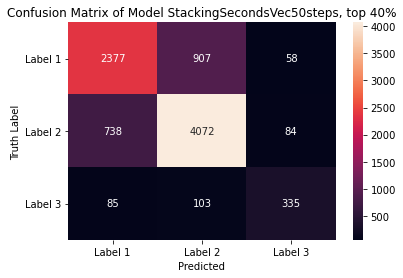

Model StackingSecondsVec50steps, top 50% has accuracy of: 77.71%, runtime 9.49 seconds
              precision    recall  f1-score   support

     Label 1       0.75      0.71      0.73      3340
     Label 2       0.80      0.83      0.82      4872
     Label 3       0.69      0.67      0.68       547

    accuracy                           0.78      8759
   macro avg       0.75      0.74      0.74      8759
weighted avg       0.78      0.78      0.78      8759



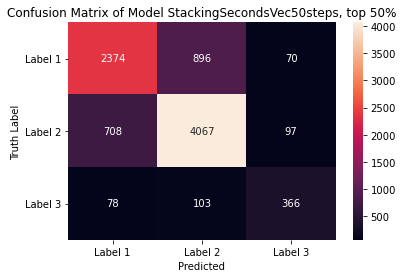

Model StackingSecondsVec50steps, top 60% has accuracy of: 76.81%, runtime 11.89 seconds
              precision    recall  f1-score   support

     Label 1       0.75      0.69      0.72      3360
     Label 2       0.79      0.83      0.81      4890
     Label 3       0.68      0.64      0.66       509

    accuracy                           0.77      8759
   macro avg       0.74      0.72      0.73      8759
weighted avg       0.77      0.77      0.77      8759



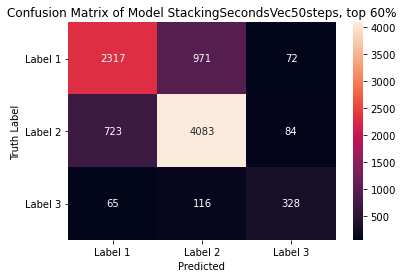

Model StackingSecondsVec50steps, top 70% has accuracy of: 77.21%, runtime 13.75 seconds
              precision    recall  f1-score   support

     Label 1       0.73      0.71      0.72      3296
     Label 2       0.80      0.82      0.81      4922
     Label 3       0.71      0.66      0.68       541

    accuracy                           0.77      8759
   macro avg       0.75      0.73      0.74      8759
weighted avg       0.77      0.77      0.77      8759



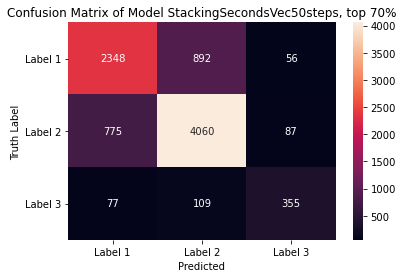

Model StackingSecondsVec50steps, top 80% has accuracy of: 77.18%, runtime 11.76 seconds
              precision    recall  f1-score   support

     Label 1       0.74      0.71      0.72      3317
     Label 2       0.81      0.82      0.81      4932
     Label 3       0.66      0.68      0.67       510

    accuracy                           0.77      8759
   macro avg       0.73      0.74      0.74      8759
weighted avg       0.77      0.77      0.77      8759



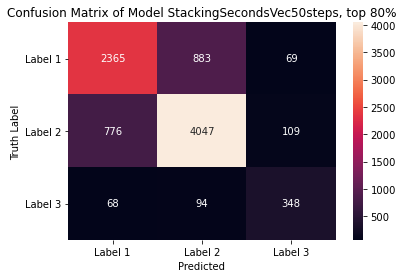

Model StackingSecondsVec50steps, top 90% has accuracy of: 77.35%, runtime 23.13 seconds
              precision    recall  f1-score   support

     Label 1       0.74      0.71      0.72      3301
     Label 2       0.80      0.83      0.82      4944
     Label 3       0.71      0.63      0.67       514

    accuracy                           0.77      8759
   macro avg       0.75      0.73      0.74      8759
weighted avg       0.77      0.77      0.77      8759



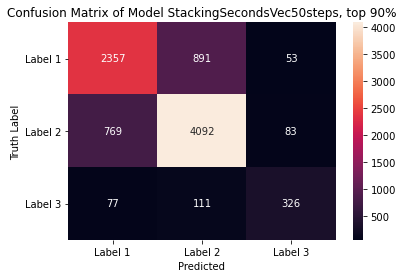

In [49]:
data = pd.concat([train_data_seconds,train_step_50],axis=1)
data = data.loc[np.isnan(data['seconds']) == False,:]
x = data.drop('duration_label',axis=1)
y = data['duration_label']

features = xtrain.columns

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = GaussianNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

for p in np.arange(10,100,10):
    k_best = SelectPercentile(mutual_info_classif, percentile=p).fit(x,y)
    topfeatures = [features[i] for i in k_best.get_support(indices=True)]
    data = pd.concat([train_data_seconds,train_step_50],axis=1).reindex(topfeatures+['duration_label'],axis=1)
    test = pd.concat([test_data_seconds,test_step_50],axis=1).reindex(topfeatures,axis=1)
    model_evaluation(sclf, f'StackingSecondsVec50steps, top {p}%', data, include_seconds=True)

Model StackingSecondsVec50steps, top 10% has accuracy of: 76.55%, runtime 8.57 seconds
              precision    recall  f1-score   support

     Label 1       0.74      0.69      0.72      3382
     Label 2       0.79      0.83      0.81      4879
     Label 3       0.72      0.66      0.68       498

    accuracy                           0.77      8759
   macro avg       0.75      0.73      0.74      8759
weighted avg       0.76      0.77      0.76      8759



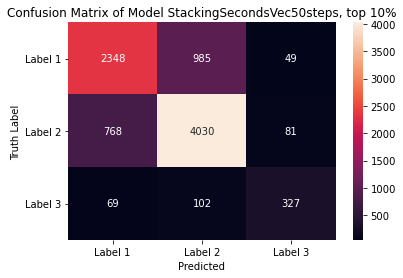

Model StackingSecondsVec50steps, top 20% has accuracy of: 76.72%, runtime 8.64 seconds
              precision    recall  f1-score   support

     Label 1       0.74      0.70      0.72      3344
     Label 2       0.80      0.83      0.81      4907
     Label 3       0.68      0.67      0.68       508

    accuracy                           0.77      8759
   macro avg       0.74      0.73      0.73      8759
weighted avg       0.77      0.77      0.77      8759



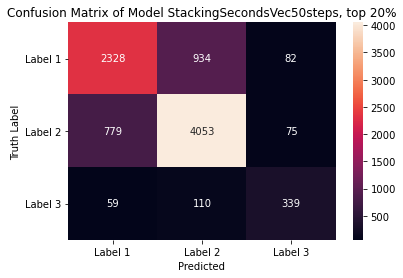

Model StackingSecondsVec50steps, top 30% has accuracy of: 76.76%, runtime 9.37 seconds
              precision    recall  f1-score   support

     Label 1       0.73      0.71      0.72      3336
     Label 2       0.80      0.82      0.81      4927
     Label 3       0.64      0.66      0.65       496

    accuracy                           0.77      8759
   macro avg       0.72      0.73      0.73      8759
weighted avg       0.77      0.77      0.77      8759



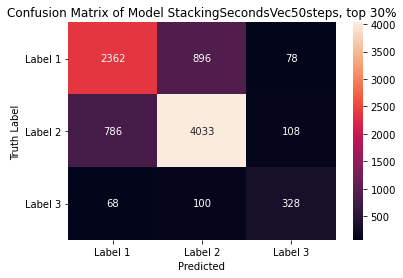

Model StackingSecondsVec50steps, top 40% has accuracy of: 77.17%, runtime 9.21 seconds
              precision    recall  f1-score   support

     Label 1       0.73      0.71      0.72      3270
     Label 2       0.80      0.82      0.81      4948
     Label 3       0.71      0.66      0.68       541

    accuracy                           0.77      8759
   macro avg       0.75      0.73      0.74      8759
weighted avg       0.77      0.77      0.77      8759



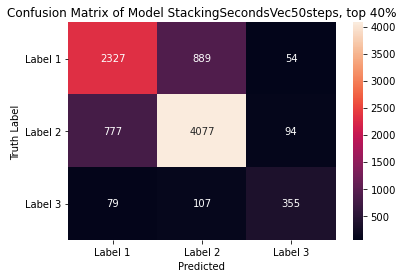

Model StackingSecondsVec50steps, top 50% has accuracy of: 77.45%, runtime 14.94 seconds
              precision    recall  f1-score   support

     Label 1       0.74      0.70      0.72      3287
     Label 2       0.81      0.83      0.82      4970
     Label 3       0.65      0.66      0.65       502

    accuracy                           0.77      8759
   macro avg       0.73      0.73      0.73      8759
weighted avg       0.77      0.77      0.77      8759



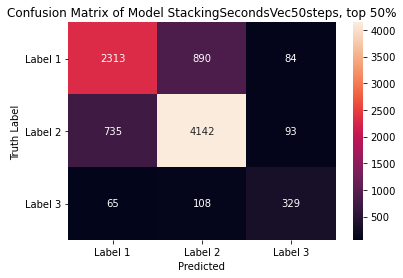

Model StackingSecondsVec50steps, top 60% has accuracy of: 76.64%, runtime 14.88 seconds
              precision    recall  f1-score   support

     Label 1       0.74      0.69      0.72      3361
     Label 2       0.79      0.83      0.81      4890
     Label 3       0.65      0.67      0.66       508

    accuracy                           0.77      8759
   macro avg       0.73      0.73      0.73      8759
weighted avg       0.77      0.77      0.77      8759



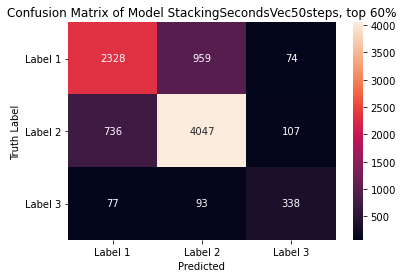

Model StackingSecondsVec50steps, top 70% has accuracy of: 77.51%, runtime 24.00 seconds
              precision    recall  f1-score   support

     Label 1       0.75      0.71      0.73      3372
     Label 2       0.80      0.83      0.82      4906
     Label 3       0.64      0.66      0.65       481

    accuracy                           0.78      8759
   macro avg       0.73      0.73      0.73      8759
weighted avg       0.77      0.78      0.77      8759



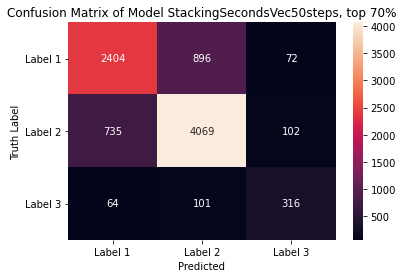

Model StackingSecondsVec50steps, top 80% has accuracy of: 76.30%, runtime 17.71 seconds
              precision    recall  f1-score   support

     Label 1       0.74      0.68      0.71      3372
     Label 2       0.78      0.83      0.81      4897
     Label 3       0.69      0.64      0.66       490

    accuracy                           0.76      8759
   macro avg       0.74      0.72      0.73      8759
weighted avg       0.76      0.76      0.76      8759



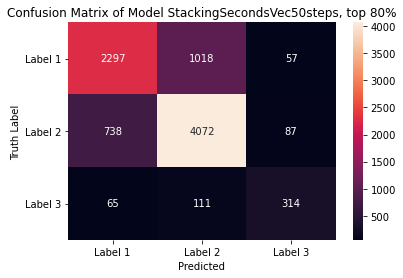

Model StackingSecondsVec50steps, top 90% has accuracy of: 76.97%, runtime 16.19 seconds
              precision    recall  f1-score   support

     Label 1       0.75      0.69      0.72      3429
     Label 2       0.79      0.84      0.81      4822
     Label 3       0.68      0.63      0.66       508

    accuracy                           0.77      8759
   macro avg       0.74      0.72      0.73      8759
weighted avg       0.77      0.77      0.77      8759



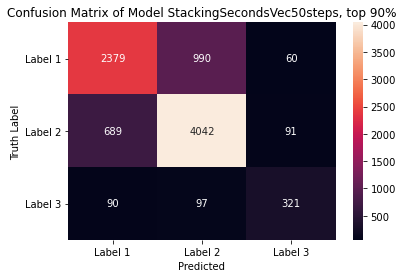

In [51]:
data = pd.concat([train_data_seconds,train_step_50],axis=1)
data = data.loc[np.isnan(data['seconds']) == False,:]
x = data.drop('duration_label',axis=1)
y = data['duration_label']

features = xtrain.columns

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = GaussianNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

for p in np.arange(10,100,10):
    k_best = SelectPercentile(mutual_info_classif, percentile=p).fit(x,y)
    topfeatures = [features[i] for i in k_best.get_support(indices=True)]
    data = pd.concat([train_data_seconds,train_step_50,train_ingr_50],axis=1).reindex(topfeatures+['duration_label'],axis=1)
    #test = pd.concat([test_data_seconds,test_step_50],axis=1).reindex(topfeatures,axis=1)
    model_evaluation(sclf, f'StackingSecondsVec50steps, top {p}%', data, include_seconds=True)